In [1]:
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

C:\Users\Luc\AppData\Local\Temp\ipykernel_29720\3364245013.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
guest_list = pd.read_csv('guest_list_full.csv')
# guest_list.head()
guest_list = guest_list.rename(columns={'Adults': 'adults', 'Children': 'kids', 'Plus 1?': 'plus_ones',
                                        'Probability of adults coming': 'adult_prob',
                                        'Probability of children coming (if parents are coming)': 'kids_prob_given_adults'})
guest_list.head()

,Guest,K or L's side,Circle,adults,kids,plus_ones,Ceremony/Reception,adult_prob,kids_prob_given_adults,Location,Comments
0,"Rivers, Kelsey",K,Must invite no questions asked,1,0,0,Both,1.0,0.0,Local,NaN
1,"Rébillout, Luc",L,Must invite no questions asked,1,0,0,Both,1.0,0.0,Local,NaN
2,"Rébillout, Serge, Monique",L,Must invite no questions asked,2,0,0,Both,1.0,0.0,International,NaN
3,"Rébillout, Adrien",L,Must invite no questions asked,1,0,1,Both,0.9,0.0,International,I don't know if he will bring Frank
4,"Flake, Nathalie, Nate, Augustine, Evalyn",L,Must invite no questions asked,2,2,0,Both,1.0,1.0,Local,NaN


In [28]:
def monte_carlo_wedding(guest_list, prob_var_range=0.1, num_simulations=1000):
    """
    Performs a Monte Carlo simulation to estimate wedding attendance.

    Args:
        guest_list: Pandas DataFrame with columns:
            - 'adults': Number of adults in the group.
            - 'plus_ones': Number of plus-ones (also adults).
            - 'kids': Number of kids in the group.
            - 'adult_prob': Probability of adults attending.
            - 'prob_var_range': Range of variation for adult_prob and kids_prob_given_adults.
            - 'kids_prob_given_adults': Conditional probability of kids attending given adults attend.
        num_simulations: Number of Monte Carlo simulations to run.

    Returns:
        Pandas DataFrame with simulation results:
            - 'total_adults_attending': Total adults attending in each simulation.
            - 'total_kids_attending': Total kids attending in each simulation.
    """

    results = []

    for _ in tqdm(range(num_simulations)):
        total_adults_attending = 0
        total_kids_attending = 0

        for _, guest in guest_list.iterrows():
            try:
                num_adults = guest['adults'] + guest['plus_ones']
                adult_prob = guest['adult_prob']
                kids_prob = guest['kids_prob_given_adults']
                num_kids = guest['kids']

                # Vary probabilities by +/- 10%
                adult_prob = np.clip(adult_prob + np.random.uniform(-np.abs(prob_var_range), np.abs(prob_var_range)), 0, 1) # Clip to ensure probabilities remain between 0 and 1
                kids_prob = np.clip(kids_prob + np.random.uniform(-np.abs(prob_var_range), np.abs(prob_var_range)), 0, 1)

                # Simulate adult attendance
                adults_attending_group = np.random.binomial(num_adults, adult_prob)
                total_adults_attending += adults_attending_group

                # Simulate kid attendance ONLY if adults from the group are attending
                if adults_attending_group > 0:
                    kids_attending_group = np.random.binomial(num_kids, kids_prob)
                    total_kids_attending += kids_attending_group
            except:
                print(guest['Guest'])

        results.append({'total_adults_attending': total_adults_attending,
                        'total_kids_attending': total_kids_attending})

    return pd.DataFrame(results)

In [29]:
simulation_results = monte_carlo_wedding(guest_list, num_simulations=10000)

100%|██████████| 10000/10000 [01:58<00:00, 84.61it/s]


In [52]:
np.random.binomial(10, 0.5)

6

In [31]:
simulation_results['total'] = simulation_results['total_adults_attending'] + simulation_results['total_kids_attending']

In [48]:
simulation_results.to_csv('wedding_monte_carlo_results.csv', index=False)

In [4]:
simulation_results = pd.read_csv('wedding_monte_carlo_results.csv')

In [5]:
# Analyze the results
print(simulation_results.describe())
print('Most common scenario:')
print(simulation_results.mode())


       total_adults_attending  total_kids_attending         total
count            10000.000000          10000.000000  10000.000000
mean               167.932300             71.027200    238.959500
std                  5.252416              4.978226      8.225486
min                148.000000             52.000000    207.000000
25%                164.000000             68.000000    233.000000
50%                168.000000             71.000000    239.000000
75%                171.000000             74.000000    244.250000
max                190.000000             93.000000    271.000000
Most common scenario:
   total_adults_attending  total_kids_attending  total
0                     168                    71    241


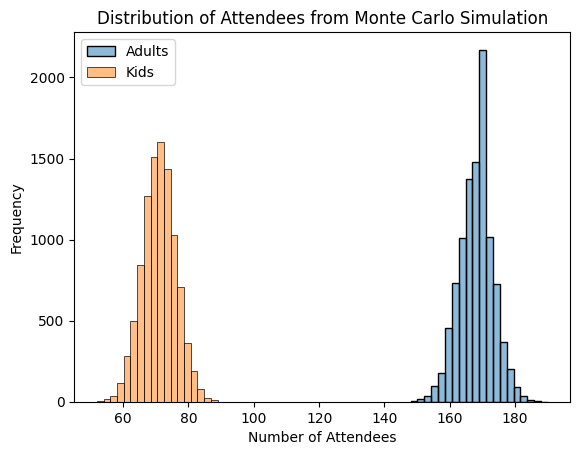

In [6]:
# Histogram using seaborn showing the portion of adults and kids contributing to the total sum

sns.histplot(data=simulation_results, x='total_adults_attending', bins=20, alpha=0.5, label='Adults')
sns.histplot(data=simulation_results, x='total_kids_attending', bins=20, alpha=0.5, label='Kids')
plt.xlabel("Number of Attendees")
plt.ylabel("Frequency")
plt.title("Distribution of Attendees from Monte Carlo Simulation")
plt.legend()

In [47]:
plt.close('all')
%matplotlib ipympl 

Text(0.5, 1.0, 'Distribution of Attendees from Monte Carlo Simulation')

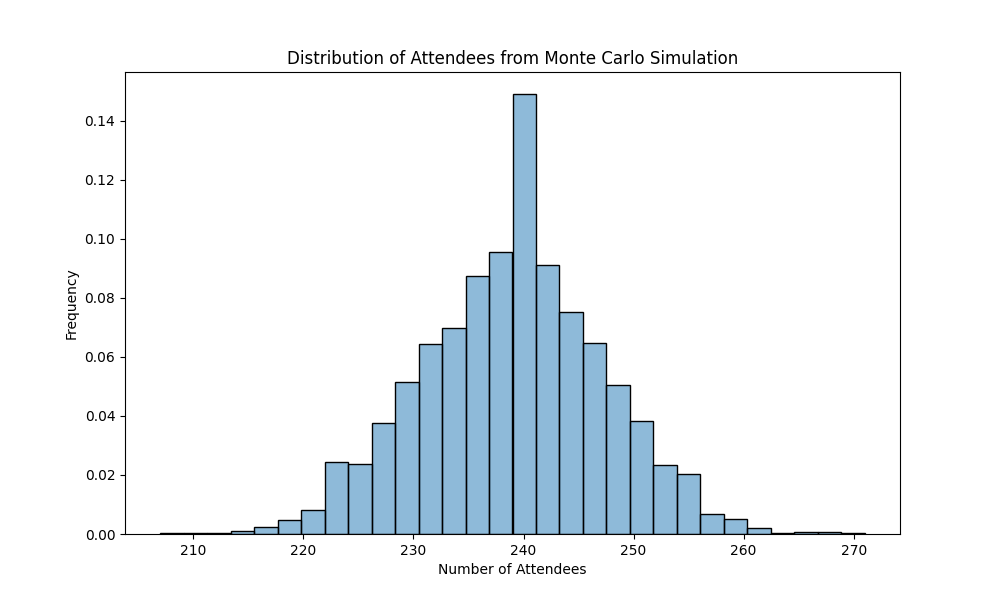

In [48]:
f, ax = plt.subplots(1, 1, figsize=(10, 6))

sns.histplot(ax=ax, data=simulation_results, stat='probability', x='total', bins=30, alpha=0.5, label='Total')
ax.set_xlabel("Number of Attendees")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Attendees from Monte Carlo Simulation")
# ax.legend()
# f.show()

Text(0.5, 1.0, 'Distribution of Attendees from Monte Carlo Simulation')

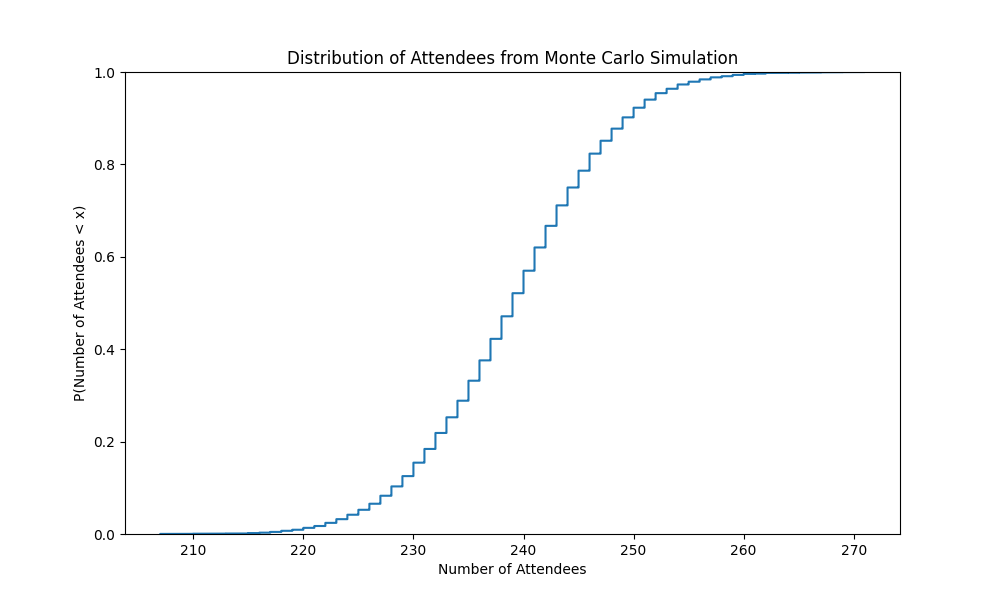

In [51]:
f1, ax1 = plt.subplots(1, 1, figsize=(10, 6))

# sns.histplot(ax=ax, data=simulation_results, stat='probability', x='total', bins=30, alpha=0.5, label='Total')
sns.ecdfplot(ax=ax1, data=simulation_results, x='total', label='Total')
ax1.set_xlabel("Number of Attendees")
ax1.set_ylabel("P(Number of Attendees < x)")
ax1.set_title("Distribution of Attendees from Monte Carlo Simulation")
# ax.legend()